In [7]:
import torch
import numpy as np
np.bool8 = np.bool_  # Fix for Gym expecting deprecated alias
import gym
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [8]:
 # --- Environment Setup ---
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
# Set a global seed
SEED = 40

# 1. Python / NumPy / Random
#random.seed(SEED)
np.random.seed(SEED)

# 2. PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 3. Gym (newer API)
env = gym.make("CartPole-v1")
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)
# --- variables ---
MAX_DATASET_SIZE = 2000

In [9]:

# --- CartPole-v1 Expert ---
class ScriptedCartPoleExpert:
    def predict(self, obs):
        angle = obs[2]
        angle_velocity = obs[3]

        # Predict where the pole is going
        future_angle = angle + 0.5 * angle_velocity

        # Move in the direction of the lean (or projected lean)
        return 0 if future_angle < 0 else 1


    def evaluateExp(self,expert, env, episodes=20):
        total = 0
        for _ in range(episodes):
            obs, _ = env.reset() #many episodes
            done = False
            while not done:  #many steps per episode 
                '''Episode End 
                    The episode ends if any one of the following occurs:
                    1.Termination: Pole Angle is greater than ±12°
                    2.Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
                    3.Truncation: Episode length is greater than 500 (200 for v0)
                    https://www.gymlibrary.dev/environments/classic_control/cart_pole/
                    '''
                action = expert.predict(obs)
                obs, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                total += reward
        return total / episodes

In [10]:
# --- BC/DAGGER Learner (Neural Network) ---
class Policy(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
    
    def forward(self, x):
        return self.net(x)

# --- Train with Behavior Cloning ---
def train_bc(expert, num_episodes=10):
    states, actions = [], []
    for _ in range(num_episodes):
        obs, _ = env.reset()  # Unpack tuple (obs, info)
        done = False
        while not done:
            action = expert.predict(obs)  # Pass obs (numpy array)
            states.append(obs)
            actions.append(action)
            next_obs, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated  # New done logic
            obs = next_obs
    return states, actions

# --- Train with DAGGER ---
def train_dagger(expert, policy, num_iterations=5):
    optimizer = optim.Adam(policy.parameters())
    states, actions = [], []
    rewards = []

    for _ in range(num_iterations):
        # --- Rollout ---
        trajectory = []
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            trajectory.append(obs)
            with torch.no_grad():
                action = torch.argmax(policy(torch.FloatTensor(obs))).item()
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            obs = next_obs
        
        rewards.append(total_reward)

        # --- Expert labeling + aggregation ---
        expert_actions = [expert.predict(s) for s in trajectory]
        states.extend(trajectory)
        actions.extend(expert_actions)
        if len(states) > MAX_DATASET_SIZE:
            states = states[-MAX_DATASET_SIZE:]
            actions = actions[-MAX_DATASET_SIZE:]
        # --- Train policy ---
        states_np = np.array(states, dtype=np.float32)
        actions_np = np.array(actions, dtype=np.int64)
        dataset = torch.utils.data.TensorDataset(
            torch.from_numpy(states_np),
            torch.from_numpy(actions_np)
        )
        loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
        #print(len(dataset))
        epochs = min(10, 3 + len(states) // 500)
        for epoch in range(epochs):
            for batch_states, batch_actions in loader:
                logits = policy(batch_states)
                loss = nn.CrossEntropyLoss()(logits, batch_actions)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    
    return (policy, rewards)

In [11]:

# --- Evaluate Policy (Fixed) ---
def evaluate(policy, num_episodes=10):
    total_reward = 0
    for _ in range(num_episodes):
        obs, _ = env.reset()  # Unpack tuple
        done = False
        while not done:
            action = torch.argmax(policy(torch.FloatTensor(obs))).item()
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            obs = next_obs
    return total_reward / num_episodes

def evaluate_policy(policy, episodes=10):
    rewards = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        total = 0
        while not done:
            with torch.no_grad():
                action = torch.argmax(policy(torch.FloatTensor(obs))).item()
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        rewards.append(total)
    return np.mean(rewards)

Expert average reward: 500.0
BC Average Reward: 401.9166666666667
DAGGER Average Reward: 493.4


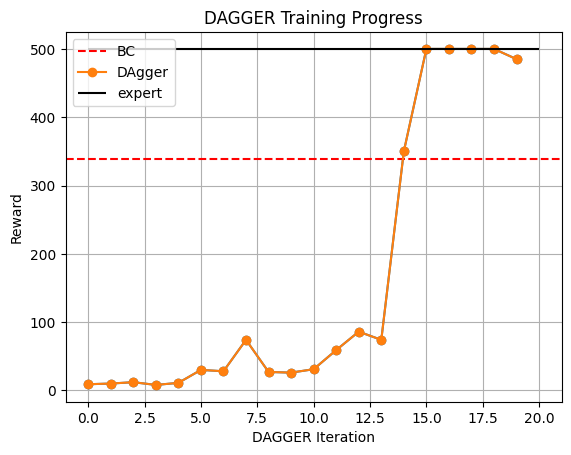

In [12]:

# --- Run Experiment ---
if __name__ == "__main__":
    expert = ScriptedCartPoleExpert()
    score = expert.evaluateExp(expert, env, episodes=20)
    print(f"Expert average reward: {score}")
    # Train BC
    (bc_states, bc_actions) = train_bc(expert)
    bc_policy = Policy()
    bc_optimizer = optim.Adam(bc_policy.parameters())
    
    bc_states_np = np.array(bc_states, dtype=np.float32)
    bc_actions_np = np.array(bc_actions, dtype=np.int64)

    bc_dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(bc_states_np),
        torch.from_numpy(bc_actions_np)
    )
    bc_loader = torch.utils.data.DataLoader(bc_dataset, batch_size=32, shuffle=True)
    for epoch in range(5):
        for states, actions in bc_loader:
            logits = bc_policy(states)
            loss = nn.CrossEntropyLoss()(logits, actions)
            bc_optimizer.zero_grad()
            loss.backward()
            bc_optimizer.step()
    
    # Train DAGGER
    dagger_policy = Policy()
    dagger_policy, dagger_rewards = train_dagger(expert, dagger_policy, num_iterations=20)

    # --- Compare ---
    print(f"BC Average Reward: {evaluate_policy(bc_policy, 60)}")
    print(f"DAGGER Average Reward: {evaluate_policy(dagger_policy, 60)}")
    
    # --- Plot reward over iterations ---
    plt.plot(dagger_rewards, marker='o')
    plt.xlabel("DAGGER Iteration")
    plt.ylabel("Reward")
    plt.title("DAGGER Training Progress")
    plt.grid(True)
    plt.axhline(evaluate_policy(bc_policy, 30), color='red', linestyle='--', label='BC')
    plt.plot(dagger_rewards, marker='o', label='DAgger')
    plt.hlines(score,xmin=0,xmax=20, color='black',label='expert')
    plt.legend()
    plt.show()
